### Preprocess the questions in the dataset

In [2]:
import os 
import numpy as np
import keras
import re
import pickle
import json
import spacy
import splitter
import enchant
import cwsplit
import time
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import threading
from IPython.display import Image

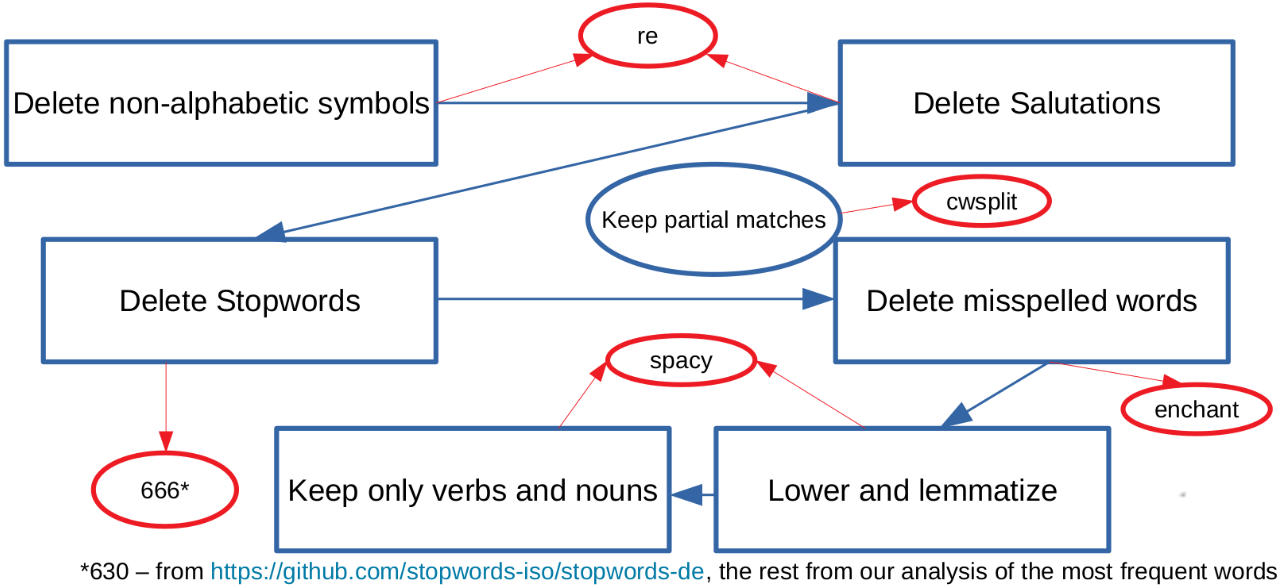

In [4]:
Image(filename='preprocessing_pipeline.png')

In [3]:
# -*- coding: utf-8 -*-
# copy of cwspit
import enchant
from itertools import groupby

__all__ = ['load_dict', 'split']

_dictionary = None


def _is_in_dict(word):
    # Some languages (e.g. German) need some words capitalized
    return _dictionary.check(word.capitalize())


def load_dict(language='de_de'):
    global _dictionary
    _dictionary = enchant.Dict(language)


def split_(word, language=None, min_word_size=3, split_on_s=True):
    if language is not None:
        load_dict(language)

    if _dictionary is None:
        load_dict()

    words = _split_crawler(word, min_word_size, split_on_s)

    # Groups words in sections such that each section contains only
    # words shorter than min word size or not shorter than min word
    # size.
    words_concat = []
    groups = [
        list(group[1])
        for group
        in groupby(
            words,
            lambda x: len(x) < min_word_size
        )
    ]

    # Concatenate sections containing shorter words than min word size.
    for group in groups:
        if len(group[0]) < min_word_size:
            group = [''.join(group)]
        words_concat.extend(group)

    # If the word is split in 2 and the 2nd word does not exist,
    # conclude it is not a compound and discard the split.
    word_is_not_compound = (
            len(words_concat) == 2
            and not _is_in_dict(words_concat[1])
    )
    if word_is_not_compound:
            return [''.join(words_concat)]

    return words_concat


def _split_crawler(word, min_word_size, split_on_s):
    word = word.lower()
    words = []

    for right_word_len in range(1, len(word)):
        split_idx = len(word) - right_word_len
        left_word = word[:split_idx]
        right_word = word[split_idx:]

        if not _is_in_dict(left_word):
            continue

        # Should help with letters 's' and alike in some languages
        if split_on_s:
            is_s = left_word[-1] == 's'
            has_length = len(left_word[:-1]) > min_word_size
            if is_s and has_length and _is_in_dict(left_word[:-1]):
                right_word = left_word[-1] + right_word
                left_word = left_word[:-1]

        words.append(left_word)

        if not _is_in_dict(right_word):
            words.extend(
                _split_crawler(right_word, min_word_size, split_on_s)
            )
            return words

        words.append(right_word)

        return words

    return [word]

In [3]:
os.chdir('disk/ERIK_ADVANCED_PRACTICAL/')

In [5]:
f = open('/home/ek/disk/ERIK_ML/stopwords.pkl','rb')

In [6]:
nlp = spacy.load('de_core_news_sm')

In [7]:
dict_ = enchant.Dict('de_DE')

In [8]:
STOPWORDS = pickle.load(f)

In [9]:
STOPWORDS = set(STOPWORDS)

In [10]:
REPLACE_BY_SPACE_RE = re.compile('[/(){}\[\]\|@,;.\\n]')
BAD_SYMBOLS_RE = re.compile('[^A-Za-züäößÖÄÜ ]')

PHRASES=re.compile(r"\bgute?n? tag\b|\bsehr geehrte damen und herren\b|\bha?e?llo\b|\bviele? grü?u?s?s?ß?e?\b|\bgute?n? morgen\b|\bdanke\b|\bbitten?\b|\bgar\b",
                   re.IGNORECASE)
STOPWORDS_REMOVE = re.compile(r'\b(?:%s)\b' % '|'.join(STOPWORDS),re.IGNORECASE)

In [11]:
stopwords_dict = {}
for i in STOPWORDS:
    stopwords_dict[i] = 1

In [15]:
def text_prepare_VN(text):
    """
        text: a string
        
        return: modified initial string
    """
    """
    TODO lowercasing should be done later. try spacy lemmatizer on the text (without lowering wall letters) 
    be
    """
    # lowercase text
    #text = text.lower()
    # replace REPLACE_BY_SPACE_RE symbols by space in text
    text = REPLACE_BY_SPACE_RE.sub(' ', text)
    # delete symbols which are in BAD_SYMBOLS_RE from text
    text = BAD_SYMBOLS_RE.sub('',text)
    text = PHRASES.sub(' ',text)
    pruned = []
    deleted = []
    def prune():
        for i in nlp(text):
            try:
                stopwords_dict[i.text.lower()]
                continue
            except KeyError:
                pass
                
            try:
                stopwords_dict[i.lemma_.lower()]
                continue
            except KeyError:
                pass
            if  (' ' not in i.text): # there were some '    ' strings
                if (i.pos_=='NOUN') or (i.pos_=='PROPN') or (i.pos_=='VERB'):
                    if len(i.text)>2 and dict_.check(i.lemma_):
                            pruned.append(i.lemma_.lower())
                    elif len(i.text) > 2 and (dict_.check(i.lemma_)== False) :
                        for j in split_(i.lemma_):
                            if dict_.check(j) and (len(j)>2) and (j.lower() not in STOPWORDS):
                                pruned.append(j.lower())
                else:
                    deleted.append(i.text)
            else:
                deleted.append(i.text)
    prune()
    #print(pruned)
    text = ' '.join(pruned)
    # delete stopwords from text
    #text = ' '.join([i for i in text.split() if (i.lower() not in STOPWORDS)])
    text = re.sub(r'\b(\w+)( \1\b)+', r'\1', text)
    return text, deleted

### Preprocess texts

In [18]:
y = []
X = []
deleted = []
start = time.time()
for file in os.listdir('Q&Adata'):
    try:
        f = open(os.path.join('Q&Adata',file),'r')
    except IsADirectoryError:
        continue
    data = json.load(f)
    print(file)
    for i in data:
        prepared = text_prepare_VN(i['question'])
        X.append(prepared[0])
        y.append(file[:-5])
        deleted+=prepared[1]
end = time.time()

Steuerrecht.json
Sozialversicherungsrecht.json
Schadensersatz.json
Baurecht & Architektenrecht.json
Internetrecht & Computerrecht.json
Mietrecht & Wohnungseigentum.json
Hauskauf & Immobilien & Grundstuecke.json
Reiserecht.json
Schule & Hochschule & Pruefungen.json
Urheberrecht & Markenrecht & Patentrecht.json
Datenschutzrecht.json
Transportrecht & Speditionsrecht.json
Gesellschaftsrecht.json
Kredite.json
Verwaltungsrecht.json
Vertragsrecht.json
Versicherungsrecht & Privatversicherungsrecht.json
Erbrecht.json
Nachbarschaftsrecht.json
Medizinrecht.json
Internetauktionen.json
Strafrecht.json
Auslaenderrecht.json
Wirtschaftsrecht & Bankrecht & Wettbewerbsrecht.json
Sozialrecht.json
Medienrecht.json
Inkasso & Mahnungen.json
Zwangsvollstreckung & Zwangsversteigerung.json
Insolvenzrecht.json
Vereinsrecht.json
Familienrecht.json
Kaufrecht.json
Arbeitsrecht.json
Verkehrsrecht.json


In [16]:
((end-start))/len(X)# with multithreading

0.026100277805328368

##### Save preprocessed dataset

In [20]:
np.save('y_full_ordered_QNA.npy',np.array(y))
f = open('X_full_ordered_VN_stopwords_QNA.pkl','wb')
pickle.dump(X,f)
f.close()

##### Load preprocessed dataset

In [4]:
f = open('X_full_ordered_VN_stopwords_QNA.pkl','rb')
X = pickle.load(f)
f.close()
y = np.load('y_full_ordered_QNA.npy')

In [5]:
N_TOPICS = np.unique(y).shape[0]

In [7]:
TOPICS = np.unique(y)

Arbeitsrecht
13750
Auslaenderrecht
2514
Baurecht & Architektenrecht
3681
Datenschutzrecht
532
Erbrecht
7693
Familienrecht
12796
Gesellschaftsrecht
1757
Hauskauf & Immobilien & Grundstuecke
2809
Inkasso & Mahnungen
1685
Insolvenzrecht
2615
Internetauktionen
2052
Internetrecht & Computerrecht
3248
Kaufrecht
5766
Kredite
883
Medienrecht
417
Medizinrecht
692
Mietrecht & Wohnungseigentum
17128
Nachbarschaftsrecht
2479
Reiserecht
832
Schadensersatz
2083
Schule & Hochschule & Pruefungen
389
Sozialrecht
5046
Sozialversicherungsrecht
1991
Steuerrecht
5568
Strafrecht
6388
Transportrecht & Speditionsrecht
227
Urheberrecht & Markenrecht & Patentrecht
2813
Vereinsrecht
499
Verkehrsrecht
3446
Versicherungsrecht & Privatversicherungsrecht
2741
Vertragsrecht
8713
Verwaltungsrecht
2132
Wirtschaftsrecht & Bankrecht & Wettbewerbsrecht
1541
Zwangsvollstreckung & Zwangsversteigerung
1025


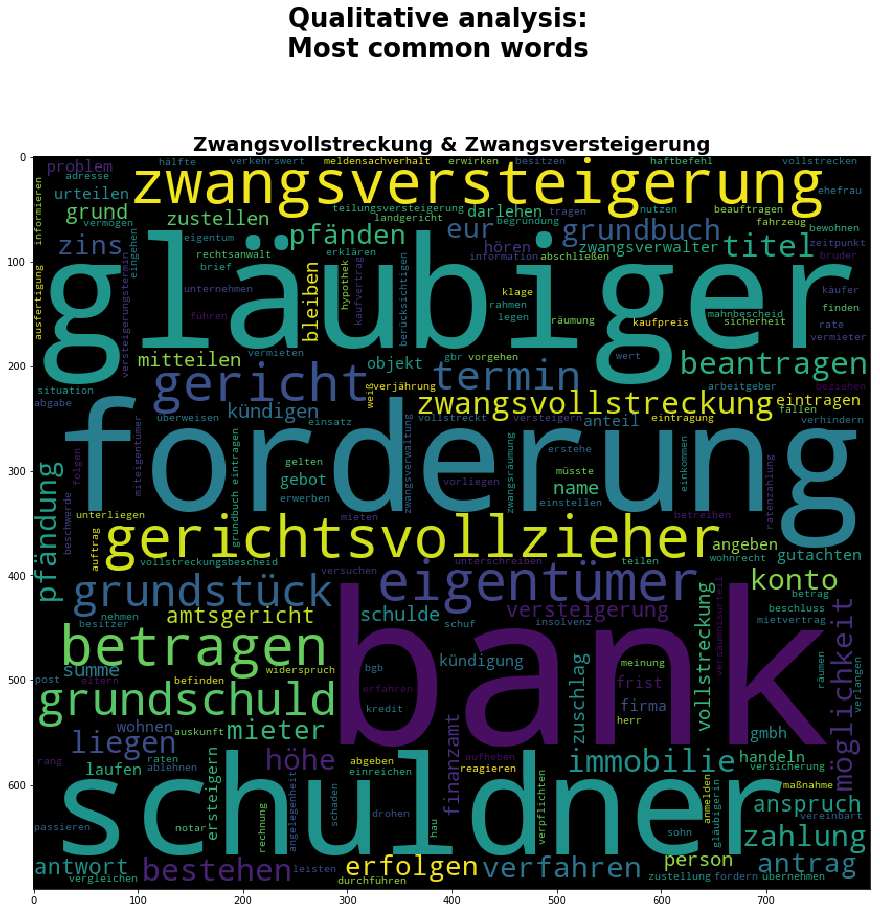

In [17]:
wc = []
fig = plt.figure(figsize=(15,15))
fig.suptitle('Qualitative analysis:\nMost common words', fontsize = 26, weight = 'bold')
ax = fig.subplots()


for i in TOPICS:
    to_ = np.where(y==i)[0][-1]
    from_ = np.where(y==i)[0][0]
    print(i)
    print(len(X[from_:to_]))
    ax.imshow(WordCloud(width=800, height=700).generate(''.join(X[from_:to_])))
    ax.set_title(i,fontsize= 20,weight='bold')
    plt.savefig('wordcloudsVN_{}.png'.format(i))



In [30]:
np.where(y=='Erbrecht')

(array([57544, 57545, 57546, ..., 65235, 65236, 65237]),)

In [32]:
X[57545]

'erben bestatte bestellen bestattungskosten aufkommen erbe schulde bestatte rechnung bestattung bank abgeben konto guthaben überweisen nachfragen weigern konto vollmacht vorliegen konto raten bestellen fallen bestellen vergütung stundenlohn konto sitzen bleiben verhalten überweisung veranlassen rest lohnen nehmen vorgehen'